In [1]:
!pip install pandas matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("datasets/dataset.csv")
df_severity = pd.read_csv("datasets/Symptom-severity.csv")
df_desc = pd.read_csv("datasets/symptom_Description.csv")
df_prec = pd.read_csv("datasets/symptom_precaution.csv")

df.columns = df.columns.str.strip()

for col in df.columns:
    df[col] = df[col].str.strip()


# Clean dataset
df_desc.columns = df_desc.columns.str.strip()
df_prec.columns = df_prec.columns.str.strip()

# Build dictionaries
description_map = dict(zip(df_desc["Disease"], df_desc["Description"]))

precaution_map = {
    row["Disease"]: [
        row["Precaution_1"],
        row["Precaution_2"],
        row["Precaution_3"],
        row["Precaution_4"],
    ]
    for _, row in df_prec.iterrows()
}

print("Cleaning Done!")
severity_map = dict(zip(df_severity["Symptom"], df_severity["weight"]))
print ("Mapping Done")

df_filled = df.copy()
symptom_cols = df_filled.columns[1:] 
for col in symptom_cols:
    df_filled[col] = df_filled[col].map(severity_map).fillna(0)
print("Replacing of Symptoms with Severity Values done")

le = LabelEncoder()
df_filled["Disease"] = le.fit_transform(df_filled["Disease"])
y = df_filled["Disease"]
X = df_filled.drop("Disease", axis=1)
print("Label Encoding Done")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)
print("Training Done!!")
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))

dt = DecisionTreeClassifier(criterion="entropy", max_depth=10)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))

knn_f1_macro = f1_score(y_test, knn_pred, average='macro')
dt_f1_macro = f1_score(y_test, dt_pred, average='macro')

knn_f1_weighted = f1_score(y_test, knn_pred, average='weighted')
dt_f1_weighted = f1_score(y_test, dt_pred, average='weighted')

print("=== F1 SCORES ===")
print(f"KNN F1 Macro: {knn_f1_macro:.4f}")
print(f"Decision Tree F1 Macro: {dt_f1_macro:.4f}")

print(f"KNN F1 Weighted: {knn_f1_weighted:.4f}")
print(f"Decision Tree F1 Weighted: {dt_f1_weighted:.4f}")

# For Prediction : 
def predict_disease(symptom_list):
    input_vector = [0] * 17
    for i, s in enumerate(symptom_list):
        if i < 17:
            input_vector[i] = severity_map.get(s.strip(), 0)

    input_vector = np.array(input_vector).reshape(1, -1)

    # Predictions
    knn_pred_label = le.inverse_transform(knn.predict(input_vector))[0]
    dt_pred_label = le.inverse_transform(dt.predict(input_vector))[0]

    final_disease = dt_pred_label

    # Get description and precautions
    description = description_map.get(final_disease, "No description available")
    precautions = precaution_map.get(final_disease, ["Not available"])

    return {
        "kNN Prediction": knn_pred_label,
        "Decision Tree Prediction": dt_pred_label,
        "Final Predicted Disease": final_disease,
        "Description": description,
        "Precautions": precautions
    }

# Testing :
test_symptoms = ["headache", "itching", "chest_pain"]

result = predict_disease(test_symptoms)
print(result)

Cleaning Done!
Mapping Done
Replacing of Symptoms with Severity Values done
Label Encoding Done
Training Done!!
KNN Accuracy: 0.9817073170731707
Decision Tree Accuracy: 0.9949186991869918
=== F1 SCORES ===
KNN F1 Macro: 0.9808
Decision Tree F1 Macro: 0.9949
KNN F1 Weighted: 0.9819
Decision Tree F1 Weighted: 0.9949
{'kNN Prediction': 'Urinary tract infection', 'Decision Tree Prediction': 'Gastroenteritis', 'Final Predicted Disease': 'Gastroenteritis', 'Description': 'Gastroenteritis is an inflammation of the digestive tract, particularly the stomach, and large and small intestines. Viral and bacterial gastroenteritis are intestinal infections associated with symptoms of diarrhea , abdominal cramps, nausea , and vomiting .', 'Precautions': ['stop eating solid food for while', 'try taking small sips of water', 'rest', 'ease back into eating']}


C:\Users\ISHAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ISHAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [3]:
import joblib

# Save models and encoder
joblib.dump(knn, "models/knn_model.pkl")
joblib.dump(dt, "models/decision_tree_model.pkl")
joblib.dump(le, "models/label_encoder.pkl")
joblib.dump(severity_map, "models/severity_map.pkl")
joblib.dump(description_map, "models/description_map.pkl")
joblib.dump(precaution_map, "models/precaution_map.pkl")

print("✅ Models and mappings saved successfully!")

✅ Models and mappings saved successfully!


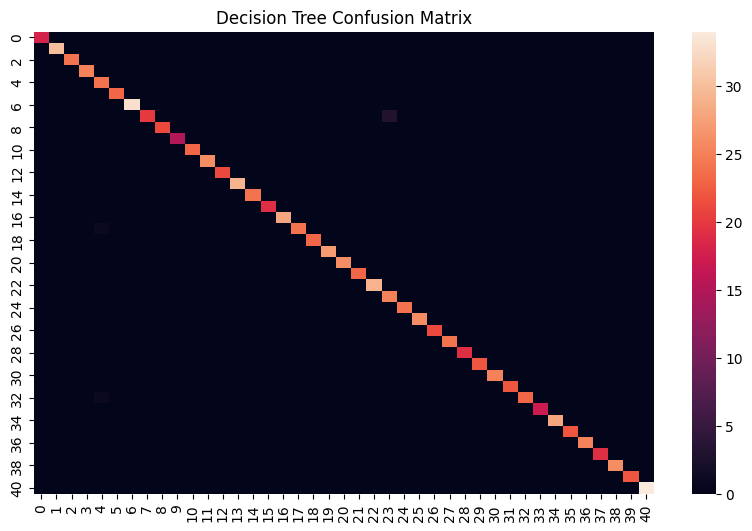

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=False)
plt.title("Decision Tree Confusion Matrix")
plt.show()